In [126]:
"""

num_fields = num_categorical_columns
num_examples = total number of examples in dataset (or batch size when training in batches)

"""

'\n\nnum_fields = num_categorical_columns\nnum_examples = total number of examples in dataset (or batch size when training in batches)\n\n'

In [127]:
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

In [128]:
# config
mlp_layers = [16,4,1]
# embedding are used as latent vector
embedding_dim = 7
learning_rate = 0.001

# example data

col_info_list = [
    {'col_name': 'feature1','col_type': 'continuous'},
    {'col_name': 'feature2','col_type': 'continuous'},
    {'col_name': 'feature3','col_type': 'continuous'},
    {'col_name': 'feature4','col_type': 'categorical'},
    {'col_name': 'feature5','col_type': 'categorical'},
    {'col_name': 'feature6','col_type': 'categorical'},
]

Y = [1, 0 , 0, 1]

df = pd.DataFrame({
    'feature1': [8.11, 8.12, 8.13, 8.14],
    'feature2': [8.21, 8.22, 8.23, 8.24],
    'feature3': [8.31, 8.32, 8.33, 8.34],
    'feature4': ['A', 'A', 'B', 'C'],
    'feature5': ['A', 'E', 'B', 'C'],
    'feature6': ['A', 'E', 'B', 'C'],
})

df

,feature1,feature2,feature3,feature4,feature5,feature6
0,8.11,8.21,8.31,A,A,A
1,8.12,8.22,8.32,A,E,E
2,8.13,8.23,8.33,B,B,B
3,8.14,8.24,8.34,C,C,C


In [129]:
# convert Y to tensor

Y = torch.tensor(Y, dtype=torch.float)
Y = Y.view(-1, 1)

# Y shape is (num_examples, 1)
Y

tensor([[1.],
        [0.],
        [0.],
        [1.]])

In [130]:
# calculate number of unique values in each categorical column

for col_info in col_info_list:
        if col_info['col_type']=='categorical':
                col_info['num_unique'] = df[col_info['col_name']].nunique()
col_info_list

[{'col_name': 'feature1', 'col_type': 'continuous'},
 {'col_name': 'feature2', 'col_type': 'continuous'},
 {'col_name': 'feature3', 'col_type': 'continuous'},
 {'col_name': 'feature4', 'col_type': 'categorical', 'num_unique': 3},
 {'col_name': 'feature5', 'col_type': 'categorical', 'num_unique': 4},
 {'col_name': 'feature6', 'col_type': 'categorical', 'num_unique': 4}]

In [131]:
# normalize continuous columns

continous_columns = [col_info['col_name'] for col_info in col_info_list if col_info['col_type']=='continuous']
x_continuous = torch.tensor(df[continous_columns].values, dtype=torch.float32)

# x_continuous shape is (num_examples, num_fields)
x_continuous

tensor([[8.1100, 8.2100, 8.3100],
        [8.1200, 8.2200, 8.3200],
        [8.1300, 8.2300, 8.3300],
        [8.1400, 8.2400, 8.3400]])

In [132]:
# label encode categorical columns

x_categorical = None
for col_info in col_info_list:
    if col_info['col_type']=='categorical':
        # load
        col_data = df[col_info['col_name']]
        num_unique_val = col_info['num_unique']
        label_encoder = LabelEncoder()
        
        # transform
        col_data = label_encoder.fit_transform(col_data)
        col_data = torch.tensor(col_data, dtype=torch.long)
        col_data = col_data.view(1, -1)

        # concat
        if x_categorical is None:
            x_categorical = col_data
        else:
            x_categorical = torch.cat((x_categorical, col_data), dim=0)
            
        # save for inference
        col_info['label_encoder'] = label_encoder

x_categorical = x_categorical.T

# x_categorical shape: (num_examples, num_fields)
x_categorical

tensor([[0, 0, 0],
        [0, 3, 3],
        [1, 1, 1],
        [2, 2, 2]])

In [133]:
class Deep(nn.Module):
    def __init__(self, input_features, mlp_layers):
        """
        Args:
            input_features: number of input features
            mlp_layers : list of hidden layer sizes
        """
        
        super().__init__()
        self.linear_layers = []
        for i in range(len(mlp_layers)):
            if i==0:
                self.linear_layers.append(nn.Linear(input_features, mlp_layers[i]))
            else:
                self.linear_layers.append(nn.Linear(mlp_layers[i-1], mlp_layers[i]))
            self.linear_layers.append(nn.ReLU())
        self.linear_layers = nn.ModuleList(self.linear_layers)
        
    def forward(self, x):
        for layer in self.linear_layers:
            x = layer(x)
        return x

Factorization machine where latent vector are implemented using embedding

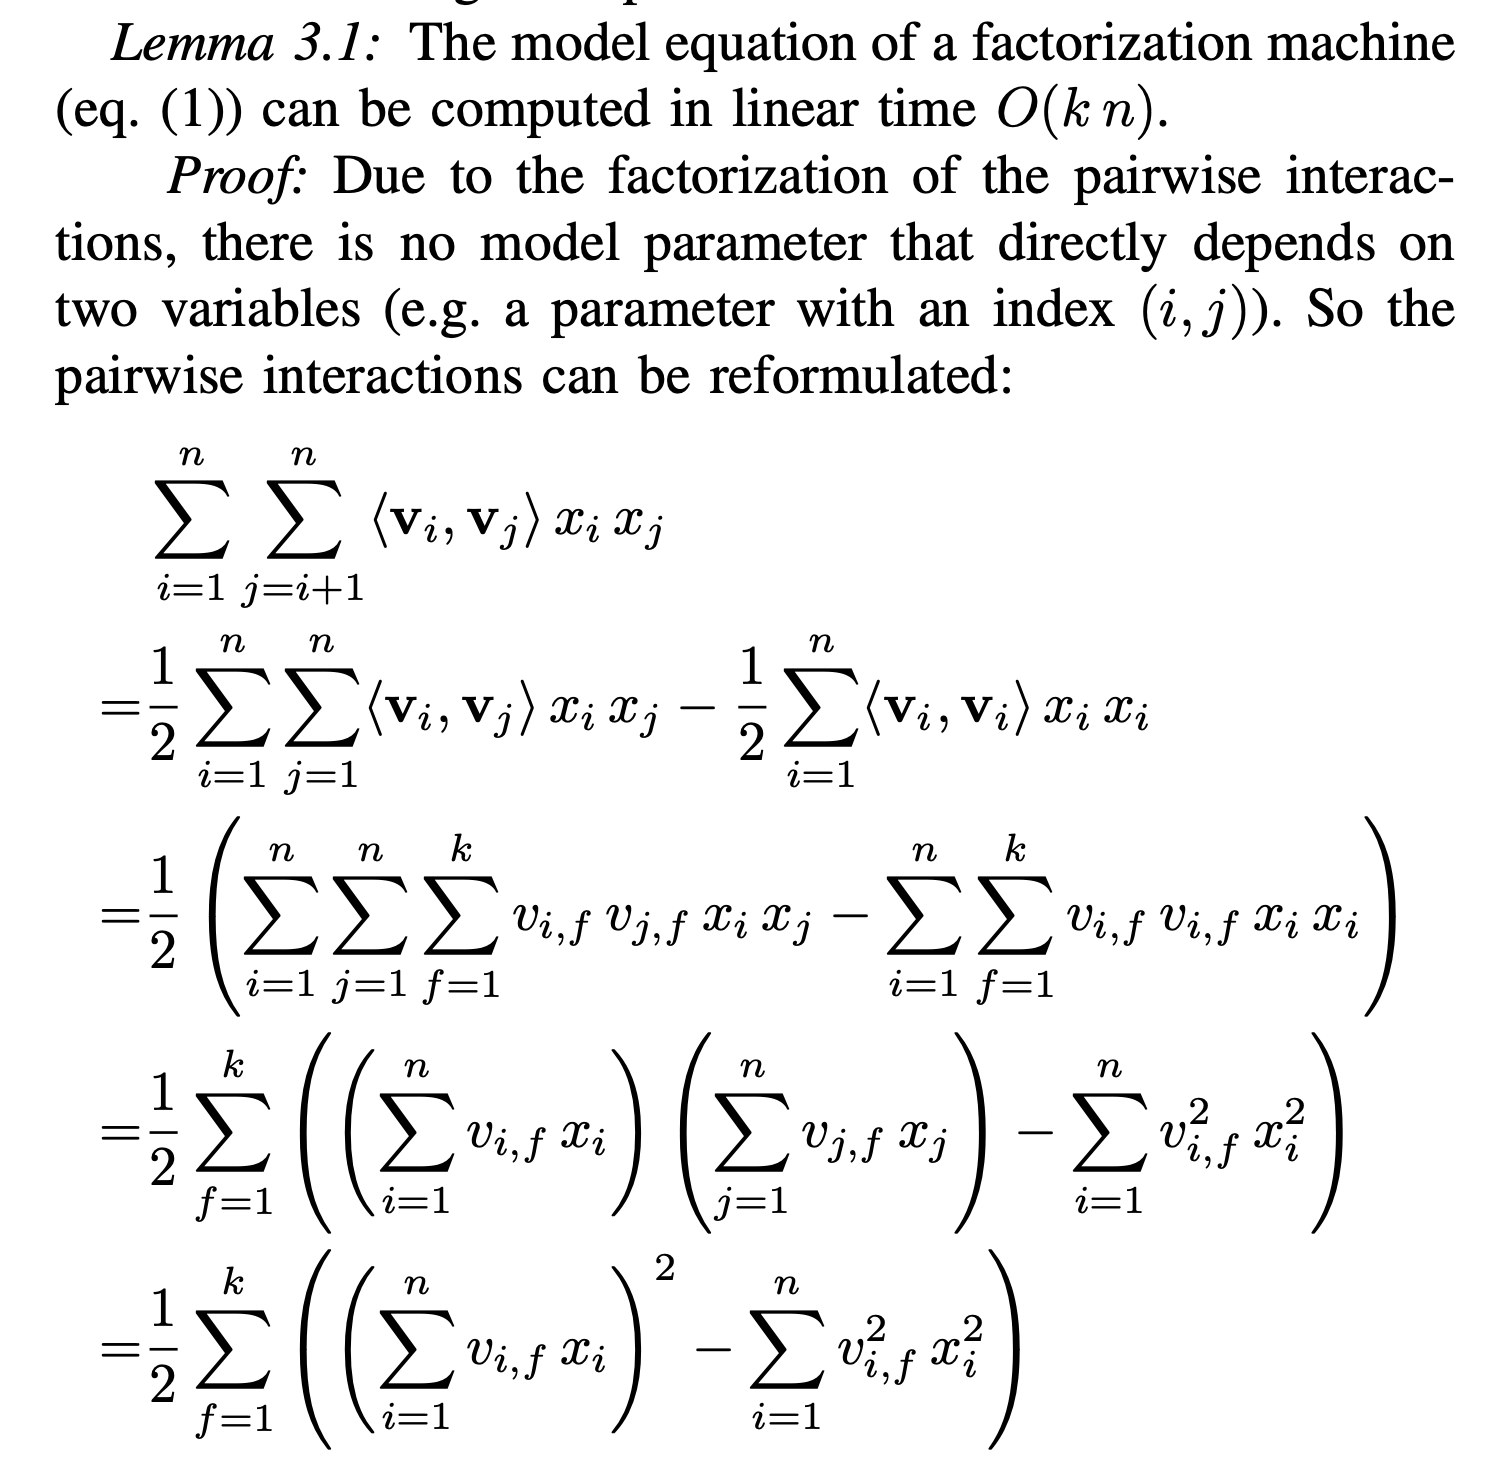

In [134]:
from IPython.display import Image, display

display(Image(filename='../../assets/images/fm.png'))

In [135]:
class FM(nn.Module):
    def __init__(self, num_features):
        """
        Args:
            num_features : number of features
        """
        super().__init__()
        self.activation = nn.Sigmoid()
        self.linear = nn.Linear(num_features, 1, bias=True)
        
    def forward(self, x_emb, x):
        # x_emb shape:                      (num_examples, num_fields, emb_dim_size)
        # x shape:                          (num_examples, num_fields)
        
        # sum all the fields and then element wise multiply all the values
        # sum_ shape:                   (num_examples, 1, emb_dim_size)
        # square_of_sum shape:          (num_examples, 1, emb_dim_size)
        sum_ = torch.sum(x_emb, dim=1, keepdim=True)
        square_of_sum = sum_ * sum_
        
        # element wise multiply multiply all the values and then sum all the fields
        # square_ shape:                   (num_examples, num_fields, emb_dim_size)
        # sum_of_square shape:          (num_examples, 1, emb_dim_size)
        square_ = x_emb * x_emb
        sum_of_square = torch.sum(square_, dim=1, keepdim=True)
        
        # Formula in above image (for order-2 features)
        # subtract (square_of_sum, sum_of_square) and sum along embedding dimension followed by mul 0.5
        order_2_output = 0.5 * torch.sum(square_of_sum - sum_of_square, dim=2, keepdim=False)
        
        # linear part (for order-1 features)
        order_1_output = self.linear(x.float())

        out = order_2_output + order_1_output
        out = self.activation(out)        
        return out

In [136]:
class DeepFM(nn.Module):
    def __init__(self, col_info_list, mlp_layers, embedding_dim):
        """
        Args:
            n: number of features
            mlp_layers : list of hidden layer sizes
        """
        super().__init__()
        
        # for embedding the categorical columns
        self.embedding_list = [nn.Embedding(col_info['num_unique'], embedding_dim) 
                               for col_info in col_info_list 
                               if col_info['col_type']=='categorical']
        self.embedding_list = nn.ModuleList(self.embedding_list)
        
        # calculate
        num_categorical_columns = len(self.embedding_list)
        num_continuous_columns = len(col_info_list) - num_categorical_columns
        input_deep_feature_size = num_categorical_columns * embedding_dim + num_continuous_columns
        
        # use it to create FM and Deep model
        self.FM_model = FM(num_categorical_columns)
        self.Deep_model = Deep(input_deep_feature_size, mlp_layers)
        self.activation = nn.Sigmoid()
        
    def forward(self, x_categorical, x_continuous):
        # x_categorical shape: (num_examples, num_fields)
        # x_continuous shape: (num_examples, num_fields)
        
        # embed features(ie values) in each field(ie columns) with their respective embeddings
        # x_categorical[:, i] shape:                        (num_examples)
        # x_categorical[:, i].view(-1,1) shape:             (num_examples, 1)
        # embedding(x_categorical[:, i].view(-1,1)) shape:  (num_examples, 1, emb_dim_size)
        # x_categorical_embedded shape:                     list of (num_examples, 1, emb_dim_size)
        x_categorical_embedded = [embedding(x_categorical[:, i].view(-1,1)) for i, embedding in enumerate(self.embedding_list)]

        # x_categorical_embedded shape: (num_examples, num_fields, emb_dim_size)
        x_categorical_embedded = torch.cat(x_categorical_embedded, dim=1)

        # get output from FM and Deep part
        # y_fm shape: (num_examples, 1)
        y_fm = self.FM_model(x_categorical_embedded, x_categorical)
        
        # x_categorical_embedded is merged field wise and sent to Deep model along with x_continuous
        # x_categorical_embedded_field_merged shape:    (num_examples, num_fields * emb_dim_size)
        # y_deep_input shape:                           (num_examples, num_fields * emb_dim_size + num_continous_columns)
        # y_deep shape:                                 (num_examples, 1)
        x_categorical_embedded_field_merged = x_categorical_embedded.view(x_categorical_embedded.shape[0], -1)
        y_deep_input = torch.cat([x_categorical_embedded_field_merged, x_continuous], dim=1)
        y_deep = self.Deep_model(y_deep_input)
        
        # Add both and sigmoid
        y = self.activation(y_fm + y_deep)
        return y

In [137]:
# initialize and check output of model
model = DeepFM(col_info_list, mlp_layers, embedding_dim)
out = model(x_categorical, x_continuous)
out

tensor([[0.7338],
        [0.7404],
        [0.7432],
        [0.7620]], grad_fn=<SigmoidBackward0>)

In [138]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(10):
    model.train()
    output = model(x_categorical, x_continuous)
    loss = criterion(output, Y)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.8224307894706726
Epoch 1, Loss: 0.8186163902282715
Epoch 2, Loss: 0.8140752911567688
Epoch 3, Loss: 0.8084858655929565
Epoch 4, Loss: 0.8049510717391968
Epoch 5, Loss: 0.8029749989509583
Epoch 6, Loss: 0.8009386658668518
Epoch 7, Loss: 0.7988566756248474
Epoch 8, Loss: 0.7970452308654785
Epoch 9, Loss: 0.7951071262359619
